In [3]:
import os
import glob
import torch
import tqdm
import random
import numpy as np
import torch.nn as nn
from PIL import Image
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms, models, datasets 
from torchvision.utils import save_image
import torch.nn.functional as F

In [4]:
class VGG(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = [3, 8, 15, 22]
        self.vgg = models.vgg16(pretrained=True).features[:23]

        for param in self.vgg.parameters():
            param.requires_grad = False
    
    def forward(self, x):
        features = []
        for i, layer in enumerate(self.vgg):
            x = layer(x)
            if i in self.layers:
                features.append(x)

        return features

In [5]:
class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, upsample=False, normalize=True, relu=True):
        super().__init__()
        self.upsample = upsample
        self.block = nn.Sequential(nn.ReflectionPad2d(kernel_size // 2), 
                                   nn.Conv2d(in_channels, out_channels, kernel_size, stride))
        
        self.norm = nn.InstanceNorm2d(out_channels, affine=True) if normalize else None
        self.relu = relu

    def forward(self, x):
        if self.upsample:
            x = F.interpolate(x, scale_factor=2)
        x = self.block(x)

        if self.norm is not None:
            x = self.norm(x)
        if self.relu:
            x = F.relu(x)

        return x

In [6]:
class ResidualBlock(torch.nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(ConvBlock(channels, channels, kernel_size=3, stride=1, normalize=True, relu=True), 
                                   ConvBlock(channels, channels, kernel_size=3, stride=1, normalize=True, relu=False))

    def forward(self, x):
        return self.block(x) + x

In [7]:
class Transformer(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(ConvBlock(3, 32, kernel_size=9, stride=1), 
                                   ConvBlock(32, 64, kernel_size=3, stride=2), 
                                   ConvBlock(64, 128, kernel_size=3, stride=2), 
                                   ResidualBlock(128), 
                                   ResidualBlock(128), 
                                   ResidualBlock(128), 
                                   ResidualBlock(128), 
                                   ResidualBlock(128), 
                                   ConvBlock(128, 64, kernel_size=3, upsample=True), 
                                   ConvBlock(64, 32, kernel_size=3, upsample=True), 
                                   ConvBlock(32, 3, kernel_size=9, stride=1, normalize=False, relu=False))

    def forward(self, x):
        return self.model(x)

In [8]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [9]:
def get_gram_matrix(y):
    (b, c, h, w) = y.shape
    features = y.view(b, c, w * h)

    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (c * h * w)

    return gram

In [10]:
def train_transform(image_size):
    transform = transforms.Compose([transforms.Resize((int(image_size * 1.15), int(image_size * 1.15))), 
                                    transforms.RandomCrop((image_size, image_size)), 
                                    transforms.ToTensor(), 
                                    transforms.Normalize(mean, std)])
    
    return transform

In [11]:
def style_transform(image_size=None):
    if image_size:
        resize = [transforms.Resize((image_size, image_size))]
    else:
        resize = []

    transform = transforms.Compose(resize + [transforms.ToTensor(), transforms.Normalize(mean, std)])
    return transform

In [12]:
def denorm(tensor):
    for c in range(3):
        tensor[:, c].mul_(std[c]).add_(mean[c])

    return tensor

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 2001
batch_size = 4
image_size = 256
lamdba_content = 1e5
lambda_style = 1e10
lr = 1e-3

In [14]:
device

device(type='cuda')

In [15]:
train_data = datasets.ImageFolder("content_images/", train_transform(image_size))
train_batches = DataLoader(train_data, batch_size=batch_size, num_workers=2, pin_memory=True)

In [16]:
len(train_data), len(train_batches)

(10, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256])


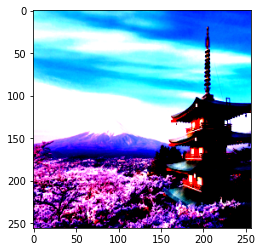

In [17]:
img, _ = train_data[9]
print(img.shape)
plt.imshow(img.permute(1, 2, 0))

In [18]:
for X, _ in train_batches:
    print(X.shape)
    break

torch.Size([4, 3, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256])


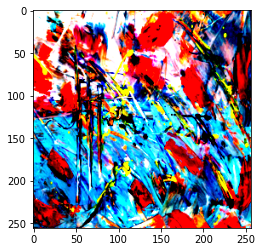

In [19]:
style_image = Image.open("style_images/abstract.jpg")
style_image = style_transform(image_size)(style_image)
print(style_image.shape)
plt.imshow(style_image.permute(1, 2, 0))

In [20]:
style_images = style_image.repeat(batch_size, 1, 1, 1).to(device)
style_images.shape

torch.Size([4, 3, 256, 256])

In [21]:
transformer = Transformer().to(device)
vgg = VGG().to(device)

In [22]:
opt = torch.optim.Adam(transformer.parameters(), lr)
loss_fn = nn.MSELoss()

In [23]:
inp = torch.randn(1, 3, 256, 256).to(device)
out = transformer(inp)
out.shape

torch.Size([1, 3, 256, 256])

In [24]:
style_features = vgg(style_images)
for sf in style_features:
    print(sf.shape)

torch.Size([4, 64, 256, 256])
torch.Size([4, 128, 128, 128])
torch.Size([4, 256, 64, 64])
torch.Size([4, 512, 32, 32])


In [25]:
style_grams = [get_gram_matrix(sf) for sf in style_features]
for sg in style_grams:
    print(sg.shape)

torch.Size([4, 64, 64])
torch.Size([4, 128, 128])
torch.Size([4, 256, 256])
torch.Size([4, 512, 512])


In [26]:
def save_checkpoint(net, filename):
    check_point = {"net_dict": net.state_dict()}
    torch.save(check_point, filename)
    print("checkpoint saved!")
    print("")

def load_checkpoint(net, filename):
    check_point = torch.load(filename)
    net.load_state_dict(check_point["net_dict"])
    print("checkpoint loaded!")
    print("")

In [27]:
image_samples = []
for path in random.sample(glob.glob("content_images/*/*.jpg"), 4):
    image_samples += [style_transform(image_size)(Image.open(path))]

image_samples = torch.stack(image_samples).to(device)

def save_output_images(epoch):
    transformer.eval()
    with torch.no_grad():
        output = transformer(image_samples)
    
    output = denorm(output.cpu())
    save_image(output, f"output_{epoch}.png", nrow=2)
    print("images saved!")
    print("")

In [ ]:
for epoch in range(epochs):
    batch_losses = []
    transformer.train()

    for X, _ in train_batches:
        images_original = X.to(device)
        images_transformed = transformer(images_original)

        features_original = vgg(images_original)
        features_transformed = vgg(images_transformed)

        content_loss = loss_fn(features_transformed[1], features_original[1]) # only relu2_2 layer

        style_loss = 0
        for ft, sg in zip(features_transformed, style_grams):
            fg = get_gram_matrix(ft)
            style_loss += loss_fn(fg, sg[:X.shape[0], :, :].to(device))
        
        total_loss = (lambda_style * style_loss) + (lamdba_content * content_loss)
        opt.zero_grad()
        total_loss.backward()
        opt.step()
        batch_losses.append(total_loss.item())

    if epoch % 100 == 0:
        loss = np.mean(batch_losses)
        print(f"epoch: {epoch} | loss: {loss:.4f}")
        save_output_images(epoch)

    if epoch % 500 == 0:
        save_checkpoint(transformer, f"checkpoint_{epoch}.pth.tar")

In [30]:
def paint_image(image_name):
    img = Image.open(image_name)
    img = style_transform()(img)
    img = img.unsqueeze(0).to(device)

    transformer.eval()
    with torch.no_grad():
        output = transformer(img)

    output = denorm(output)
    save_image(output, "output.png", nrow=1)

In [ ]:
paint_image("input.jpg")